## Cluster our data
Mostly scikit-learn algorithms

In [1]:
import pandas as pd
import spacy
import umap
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/yl238/projects/ml-app-deploy/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
from ml_editor.data_processing import format_raw_df, get_split_by_author
from ml_editor.data_processing import get_vectorized_series, train_vectorizer
from ml_editor.data_processing import add_text_features_to_df

In [6]:
data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = add_text_features_to_df(df.loc[df['is_question']].copy())

In [7]:
train_author, test_author = get_split_by_author(df[df['is_question']])

In [8]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'tagger', 'ner', 'textcat'])
train_author['vectors'] = train_author['full_text'].apply(lambda x: nlp(x).vector)
vectorized_features = np.vstack(train_author['vectors'])

In [10]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

Now let us cluster the data using K-means. K-means requires us to input the desired number of clusters as a parameter. Let's start with three clusters, and visualize our results using UMAP by assigning each cluster a different color.

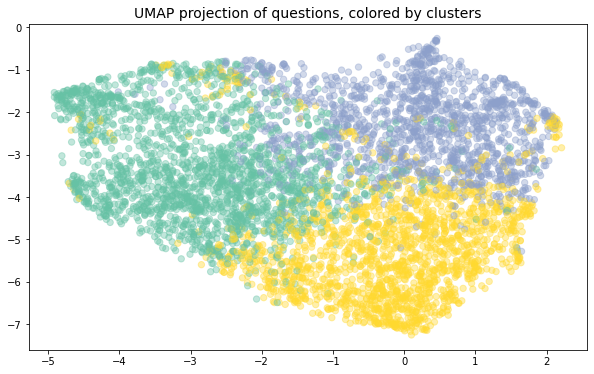

In [12]:
# Choose number of clusters and colormap
n_clusters = 3
cmap = plt.get_cmap('Set2')
f, ax = plt.subplots(figsize=(10, 6))

# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# Plot the dimensionality reduced features on a 2D plane
ax.scatter(umap_features[:, 0], umap_features[:, 1],
           c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
ax.set_title('UMAP projection of questions, colored by clusters', fontsize=14);

Looking at this plot, it is unclear whether we have picked the right number of clusters. Certain region seem to be associated to a unique cluster, while others are split. Let's try different cluster numbers and plot the umap projection and silhouette scores and samples for each.

In [18]:
to_clus = vectorized_features
to_clus_len = len(to_clus)

def set_plot_dim(n_clusters, to_clus_len):
    # First subplot is the silhouette plot
    ax1.set_xlim([-.3, .4])
    # Insert blanks to demarcate
    ax1.set_ylim([0, to_clus_len + (n_clusters + 1) * 10])
    return ax1

In [20]:
def cluster_and_compute_silhouette(to_clus, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(to_clus)
    
    silhouette_avg = silhouette_score(to_clus, cluster_labels, metric='cosine')
    print('For n_clusters = {}'.format(n_clusters),
         'The average silhouette score is: {}'.format(silhouette_avg))
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(to_clus, cluster_labels, metric='cosine')
    return clusterer.cluster_centers_, cluster_labels, silhouette_avg, sample_silhouette_values

In [16]:
def aggregate_sort_ss(i, n_clusters, cluster_labels,
                     sample_silhouette_values):
    ith_cluster_silhouette_value = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_value.sort()
    
    size_cluster_i = ith_cluster_silhouette_value.shape[0]
    return size_cluster_i, ith_cluster_silhouette_value

For n_clusters = 2 The average silhouette score is: 0.17765015363693237
For n_clusters = 3 The average silhouette score is: 0.08359628170728683
For n_clusters = 4 The average silhouette score is: 0.06700175255537033
For n_clusters = 5 The average silhouette score is: 0.06320279836654663
For n_clusters = 6 The average silhouette score is: 0.04370136559009552


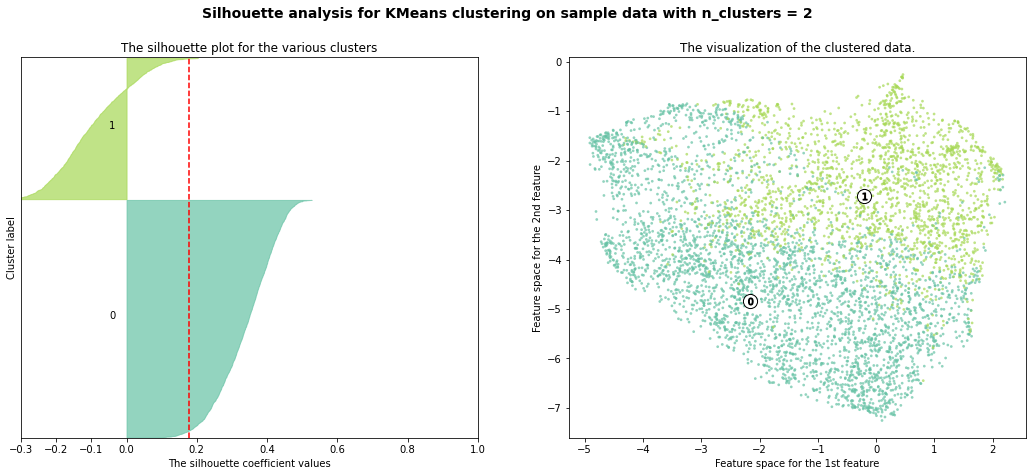

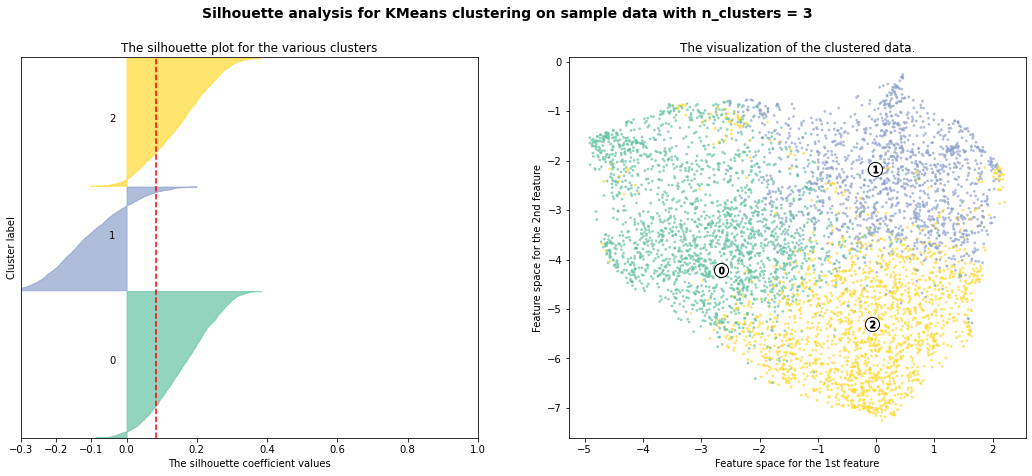

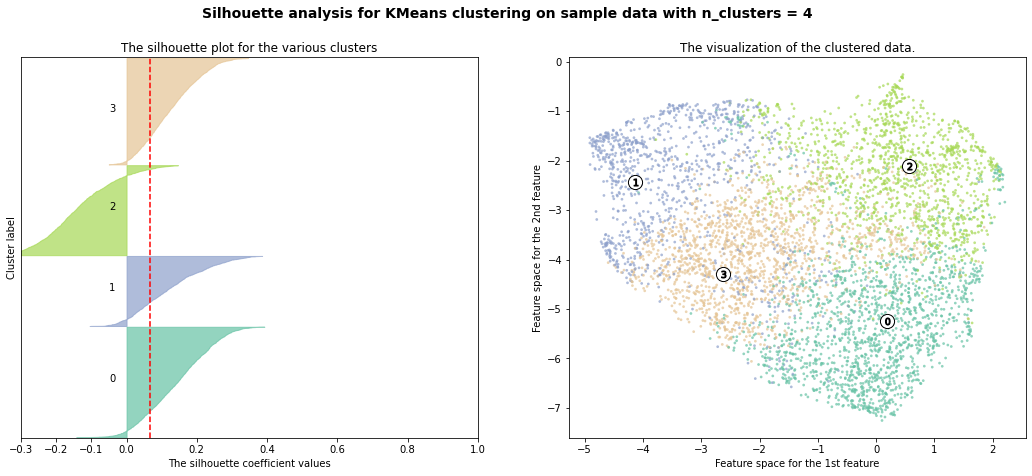

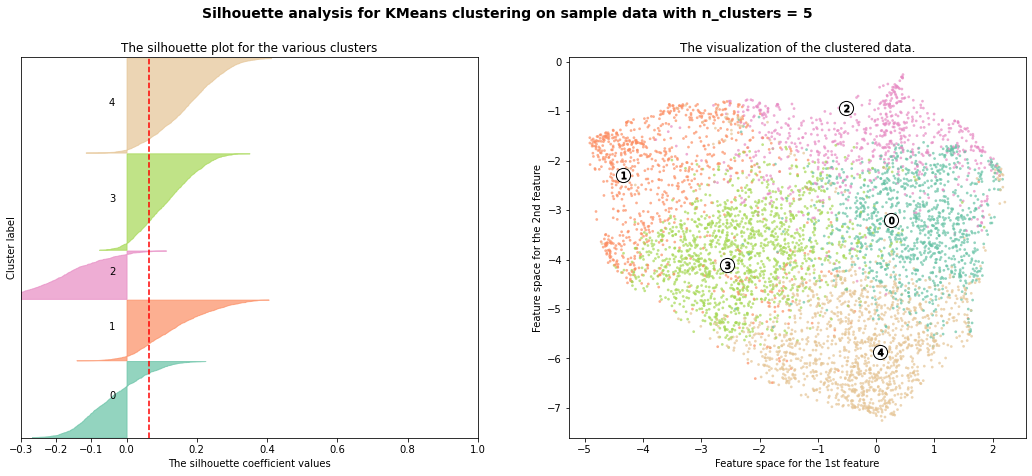

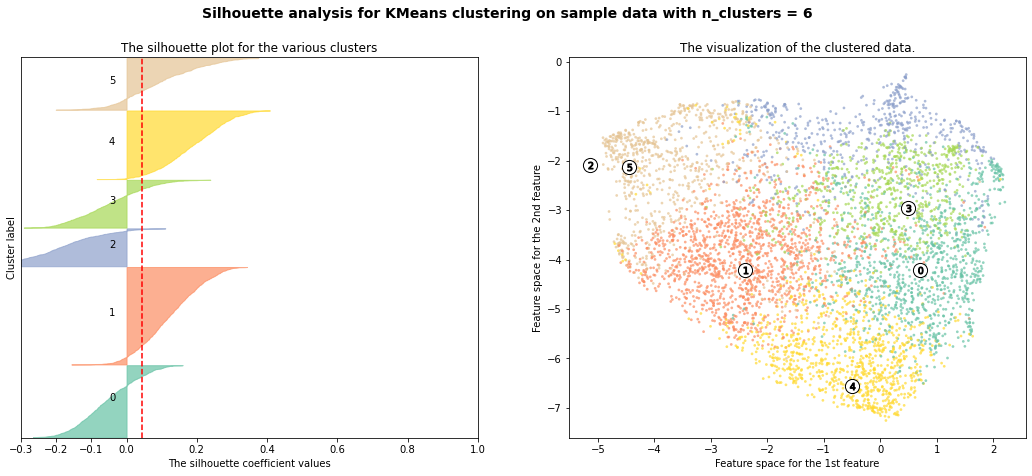

In [22]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18, 7)
    ax1 = set_plot_dim(n_clusters, to_clus_len)
    c_centers, c_labels, silhouette_avg, sample_silhouette_values = cluster_and_compute_silhouette(to_clus, n_clusters)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        size_cluster_i, ith_cluster_silhouette_values = aggregate_sort_ss(i, 
                                                                         n_clusters, 
                                                                          c_labels,
                                                                         sample_silhouette_values)
        y_upper = y_lower + size_cluster_i
        color = cmap(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples
    
    ax1.set_title('The silhouette plot for the various clusters')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    ax1.set_yticks([]) # clear the yaxis labels / ticks
    ax1.set_xticks([-0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cmap(c_labels.astype(float) / n_clusters)
    ax2.scatter(umap_features[:, 0], umap_features[:, 1], marker='.',
               s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    # Labelling the clusters
    centers = umap_embedder.transform(c_centers)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

The aggregate silhouette score is often too high level of a metric to judge clustering quality. To show a more nuanced view, silhouette plots display each individual data point's silhouette score broken down by cluster. 